In [13]:
import config
import scraping.transform, scraping.parse, scraping.fetch
from features.build_features import add_team_column
import pandas as pd
import requests
from bs4 import BeautifulSoup
from time import sleep
import cloudscraper

In [14]:
import sqlite3
with sqlite3.connect(config.DB_PATH) as conn:
    c = conn.cursor()
    c.execute("DROP TABLE IF EXISTS team_stats_raw")
    conn.commit()

In [15]:
import scraping.fetch
from db.init_db import initialize_database
initialize_database()


url = "https://fbref.com/en/comps/9/Premier-League-Stats"
html_res = scraping.fetch.fetch_url(url)
print(html_res)


<!DOCTYPE html>
<html data-version="klecko-" data-root="/home/fb/deploy/www" lang="en" class="no-js" >
<head>
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />
    <link rel="dns-prefetch" href="https://cdn.ssref.net/req/202507021" />
<script>
/* https://docs.osano.com/hc/en-us/articles/22469433444372-Google-Consent-Mode-v2  */
  window.dataLayer = window.dataLayer ||[];
      function gtag(){dataLayer.push(arguments);}
      gtag('consent','default',{
        'ad_storage':'denied',
        'analytics_storage':'denied',
        'ad_user_data':'denied',
        'ad_personalization':'denied',
        'personalization_storage':'denied',
        'functionality_storage':'granted',
        'security_storage':'granted',
        'wait_for_update': 500
      });
      gtag("set", "ads_data_redaction", true);
</script>
<script src="https://cmp.osano.com/16CGnCU8UtNh

In [16]:
#testy czemu nie dzialalo 

def debug_response(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/131.0.0.0 Safari/537.36'
    }
    
    try:
        response = requests.get(url, headers=headers, timeout=15)
        print(f"Status code: {response.status_code}")
        print(f"Headers: {response.headers}")
        print(f"Response text (first 500 chars): {response.text[:500]}")
        print(f"Final URL: {response.url}")
    except requests.RequestException as e:
        print(f"Exception: {e}")
        print(f"Response: {e.response}")
        if hasattr(e.response, 'text'):
            print(f"Response text: {e.response.text[:500]}")

# Sprawdź
debug_response("https://fbref.com/en/comps/9/Premier-League-Stats")

Status code: 403
Headers: {'Date': 'Mon, 07 Jul 2025 22:05:32 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Transfer-Encoding': 'chunked', 'Connection': 'close', 'accept-ch': 'Sec-CH-UA-Bitness, Sec-CH-UA-Arch, Sec-CH-UA-Full-Version, Sec-CH-UA-Mobile, Sec-CH-UA-Model, Sec-CH-UA-Platform-Version, Sec-CH-UA-Full-Version-List, Sec-CH-UA-Platform, Sec-CH-UA, UA-Bitness, UA-Arch, UA-Full-Version, UA-Mobile, UA-Model, UA-Platform-Version, UA-Platform, UA', 'cf-mitigated': 'challenge', 'critical-ch': 'Sec-CH-UA-Bitness, Sec-CH-UA-Arch, Sec-CH-UA-Full-Version, Sec-CH-UA-Mobile, Sec-CH-UA-Model, Sec-CH-UA-Platform-Version, Sec-CH-UA-Full-Version-List, Sec-CH-UA-Platform, Sec-CH-UA, UA-Bitness, UA-Arch, UA-Full-Version, UA-Mobile, UA-Model, UA-Platform-Version, UA-Platform, UA', 'cross-origin-embedder-policy': 'require-corp', 'cross-origin-opener-policy': 'same-origin', 'cross-origin-resource-policy': 'same-origin', 'origin-agent-cluster': '?1', 'permissions-policy': 'accelerometer=(),auto

In [17]:
import cloudscraper
from time import sleep

def fetch_fbref_cloudscraper(url, retries=3):
    scraper = cloudscraper.create_scraper(
        browser={
            'browser': 'chrome',
            'platform': 'windows',
            'mobile': False
        }
    )
    
    for i in range(retries):
        try:
            response = scraper.get(url)
            if response.status_code == 200:
                return response.text
            print(f"Status: {response.status_code}")
        except Exception as e:
            print(f"Próba {i+1}: {e}")
            sleep(2)
    
    return None

# Użyj
html = fetch_fbref_cloudscraper("https://fbref.com/en/comps/9/Premier-League-Stats")
if html:
    print("✅ Cloudscraper zadziałał!")
    print(f"HTML length: {len(html)}")
else:
    print("❌ Cloudscraper nie zadziałał")

print(html)

✅ Cloudscraper zadziałał!
HTML length: 1351374

<!DOCTYPE html>
<html data-version="klecko-" data-root="/home/fb/deploy/www" lang="en" class="no-js" >
<head>
    <meta charset="utf-8">
    <meta http-equiv="x-ua-compatible" content="ie=edge">
    <meta name="viewport" content="width=device-width, initial-scale=1.0, maximum-scale=2.0" />
    <link rel="dns-prefetch" href="https://cdn.ssref.net/req/202507021" />
<script>
/* https://docs.osano.com/hc/en-us/articles/22469433444372-Google-Consent-Mode-v2  */
  window.dataLayer = window.dataLayer ||[];
      function gtag(){dataLayer.push(arguments);}
      gtag('consent','default',{
        'ad_storage':'denied',
        'analytics_storage':'denied',
        'ad_user_data':'denied',
        'ad_personalization':'denied',
        'personalization_storage':'denied',
        'functionality_storage':'granted',
        'security_storage':'granted',
        'wait_for_update': 500
      });
      gtag("set", "ads_data_redaction", true);
</script>


In [18]:
import scraping.parse


teams, full_links = scraping.parse.parse_team_links(html_res)
print(teams, full_links)

['Liverpool', 'Arsenal', 'Manchester City', 'Chelsea', 'Newcastle United', 'Aston Villa', 'Nottingham Forest', 'Brighton and Hove Albion', 'Bournemouth', 'Brentford', 'Fulham', 'Crystal Palace', 'Everton', 'West Ham United', 'Manchester United', 'Wolverhampton Wanderers', 'Tottenham Hotspur', 'Leicester City', 'Ipswich Town', 'Southampton'] ['https://fbref.com/en/squads/822bd0ba/2024-2025/Liverpool-Stats', 'https://fbref.com/en/squads/18bb7c10/2024-2025/Arsenal-Stats', 'https://fbref.com/en/squads/b8fd03ef/2024-2025/Manchester-City-Stats', 'https://fbref.com/en/squads/cff3d9bb/2024-2025/Chelsea-Stats', 'https://fbref.com/en/squads/b2b47a98/2024-2025/Newcastle-United-Stats', 'https://fbref.com/en/squads/8602292d/Aston-Villa-Stats', 'https://fbref.com/en/squads/e4a775cb/Nottingham-Forest-Stats', 'https://fbref.com/en/squads/d07537b9/Brighton-and-Hove-Albion-Stats', 'https://fbref.com/en/squads/4ba7cbea/Bournemouth-Stats', 'https://fbref.com/en/squads/cd051869/Brentford-Stats', 'https://f

In [19]:
# import scraping.fetch, scraping.parse, scraping.transform
# import features.build_features
# from random import uniform
# from time import sleep



# res = []
# for team_name, link in zip(teams, full_links): 
#     html = scraping.fetch.fetch_url(link) #tutaj dostaje htmal z linku
#     fixture_df = scraping.parse.parse_team_fixture_df(html)
#     full_stats_links = scraping.parse.parse_team_detailed_stats(html)
#     temp_res = scraping.parse.parse_all_stat_tables(full_stats_links)
#     merged_temp_df = scraping.transform.merge_tables(temp_res, fixture_df)
#     merged_temp_df_with_column = features.build_features.add_team_column(merged_temp_df, team_name)
#     res.append(merged_temp_df_with_column)
#     sleep(uniform(5, 10))  # losowe opóźnienie 5–10 sekund
    
# print(res)
    
    

In [20]:
# import scraping.fetch, scraping.parse, scraping.transform
# import features.build_features
# from random import uniform
# from time import sleep
# import os

# res = []

# # Katalog, w którym trzymamy HTML-e klubów
# CACHE_DIR = "data/raw"
# os.makedirs(CACHE_DIR, exist_ok=True)

# for team_name, link in zip(teams, full_links): 
#     print(f"➡️ Przetwarzam klub: {team_name}")
    
#     # Ścieżka do pliku cache
#     safe_team_name = team_name.lower().replace(" ", "_")  # np. "Man City" → "man_city"
#     html_path = os.path.join(CACHE_DIR, f"{safe_team_name}.html")

#     # 📦 Użyj cache, jeśli istnieje
#     if os.path.exists(html_path):
#         print(f"📄 Wczytuję z pliku: {html_path}")
#         with open(html_path, "r", encoding="utf-8") as f:
#             html = f.read()
#     else:
#         print(f"🌐 Pobieram HTML z sieci dla {team_name}")
#         html = scraping.fetch.fetch_url(link)
#         with open(html_path, "w", encoding="utf-8") as f:
#             f.write(html)
#         sleep(uniform(5, 10))  # ⏱️ spowolnienie tylko po realnym fetchu
    
#     try:
#         fixture_df = scraping.parse.parse_team_fixture_df(html)
#         full_stats_links = scraping.parse.parse_team_detailed_stats(html)
#         temp_res = scraping.parse.parse_all_stat_tables(full_stats_links)
#         merged_temp_df = scraping.transform.merge_tables(temp_res, fixture_df)
#         merged_temp_df_with_column = features.build_features.add_team_column(merged_temp_df, team_name)
#         res.append(merged_temp_df_with_column)
#     except Exception as e:
#         print(f"❌ Błąd podczas przetwarzania {team_name}: {e}")

# print(f"✅ Gotowe. Przetworzono {len(res)} drużyn.")


In [21]:
# with open(r"data\raw\liverpool.html", "r", encoding="utf-8") as f:
#             html = f.read()
# fixture_df = scraping.parse.parse_team_fixture_df(html)
# full_stats_links = scraping.parse.parse_team_detailed_stats(html)
# temp_res = scraping.parse.parse_all_stat_tables(full_stats_links)
# merged_temp_df = scraping.transform.merge_tables(temp_res, fixture_df)
# merged_temp_df_with_column = features.build_features.add_team_column(merged_temp_df, team_name)
# season = features.build_features.add_season_drom_date(merged_temp_df_with_column["Date"].iloc[0])
# merged_temp_df_with_column["Season"] = season
# merged_temp_df_with_column.info()

In [22]:
import scraping.fetch, scraping.parse, scraping.transform
import features.build_features
from random import uniform
from time import sleep
import os
import db.init_db, db.io

db.init_db.initialize_database()
SEASON = "2023-2024"
for team_name, link in zip(teams, full_links): 
    print(f"➡️ Przetwarzam klub: {team_name}")
    
    try:
        html = scraping.fetch.fetch_url(link)
        db.io.save_html_to_db(team_name, season = SEASON, html=html, url=link)
        print(f"✅ Zapisano HTML dla {team_name}")
    except Exception as e:
        print(f"Nie udało się zapisac HTML-a: {e}")
        
    sleep(uniform(3, 7))
        


➡️ Przetwarzam klub: Liverpool
✅ Zapisano HTML dla Liverpool


➡️ Przetwarzam klub: Arsenal
✅ Zapisano HTML dla Arsenal
➡️ Przetwarzam klub: Manchester City
✅ Zapisano HTML dla Manchester City
➡️ Przetwarzam klub: Chelsea
✅ Zapisano HTML dla Chelsea
➡️ Przetwarzam klub: Newcastle United
✅ Zapisano HTML dla Newcastle United
➡️ Przetwarzam klub: Aston Villa
✅ Zapisano HTML dla Aston Villa
➡️ Przetwarzam klub: Nottingham Forest
✅ Zapisano HTML dla Nottingham Forest
➡️ Przetwarzam klub: Brighton and Hove Albion
✅ Zapisano HTML dla Brighton and Hove Albion
➡️ Przetwarzam klub: Bournemouth
✅ Zapisano HTML dla Bournemouth
➡️ Przetwarzam klub: Brentford
✅ Zapisano HTML dla Brentford
➡️ Przetwarzam klub: Fulham
✅ Zapisano HTML dla Fulham
➡️ Przetwarzam klub: Crystal Palace
✅ Zapisano HTML dla Crystal Palace
➡️ Przetwarzam klub: Everton
✅ Zapisano HTML dla Everton
➡️ Przetwarzam klub: West Ham United
✅ Zapisano HTML dla West Ham United
➡️ Przetwarzam klub: Manchester United
✅ Zapisano HTML dla Manchester United
➡️ Przetwarzam klub: Wolverhampton Wanderers
✅

In [ ]:
res = []
for team in teams:
    html = db.io.load_html_from_db(team, season=SEASON)
    fixture_df = scraping.parse.parse_team_fixture_df(html)
    full_stats_links = scraping.parse.parse_team_detailed_stats(html)
    temp_res = scraping.parse.parse_all_stat_tables(full_stats_links)
    merged_temp_df = scraping.transform.merge_tables(temp_res, fixture_df)
    merged_temp_df_with_column = features.build_features.add_team_column(merged_temp_df, team)
    season = features.build_features.add_season_from_date(merged_temp_df_with_column["Date"].iloc[0])
    merged_temp_df_with_column["Season"] = season
    db.io.save_raw_team_data_to_db(merged_temp_df_with_column)
    res.append(merged_temp_df_with_column)



In [2]:
import db.io
man_city_raw_df = db.io.load_raw_team_stats_from_db("Manchester City", "2024-2025")
man_city_raw_df

,Date,Time,Comp,Round,Venue,Result,GF,GA,Opponent,xGA,...,Att Pen,Live,1/3,CPA,Dis,xG,Poss,PrgDist,Team,Season
0,2024-08-10,15:00,FA Community Shield,FA Community Shield,Home,D,1 (7),1 (6),Manchester Utd,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,56.0,NaN,Manchester City,2024-2025
1,2024-08-18,16:30,Premier League,Matchweek 1,Away,W,2.0,0.0,Chelsea,1.0,...,24.0,664.0,31.0,13.0,12.0,0.8,52.0,2491.0,Manchester City,2024-2025
2,2024-08-24,15:00,Premier League,Matchweek 2,Home,W,4.0,1.0,Ipswich Town,0.3,...,47.0,883.0,27.0,11.0,10.0,3.3,75.0,2774.0,Manchester City,2024-2025
3,2024-08-31,17:30,Premier League,Matchweek 3,Away,W,3.0,1.0,West Ham,0.7,...,57.0,857.0,20.0,16.0,8.0,3.0,67.0,3117.0,Manchester City,2024-2025
4,2024-09-14,15:00,Premier League,Matchweek 4,Home,W,2.0,1.0,Brentford,1.0,...,51.0,671.0,22.0,14.0,12.0,2.1,54.0,2436.0,Manchester City,2024-2025
5,2024-09-18,20:00,Champions Lg,League phase,Home,D,0.0,0.0,it Inter,0.7,...,47.0,769.0,27.0,12.0,9.0,2.3,60.0,2756.0,Manchester City,2024-2025
6,2024-09-22,16:30,Premier League,Matchweek 5,Home,D,2.0,2.0,Arsenal,0.7,...,53.0,847.0,38.0,17.0,7.0,2.1,77.0,2410.0,Manchester City,2024-2025
7,2024-09-24,19:45,EFL Cup,Third round,Home,W,2.0,1.0,Watford,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,72.0,NaN,Manchester City,2024-2025
8,2024-09-28,12:30,Premier League,Matchweek 6,Away,D,1.0,1.0,Newcastle Utd,1.6,...,38.0,705.0,22.0,12.0,8.0,0.9,62.0,2334.0,Manchester City,2024-2025
9,2024-10-01,21:00,Champions Lg,League phase,Away,W,4.0,0.0,sk Slovan Bratislava,0.1,...,77.0,904.0,39.0,19.0,10.0,3.7,75.0,3022.0,Manchester City,2024-2025


In [3]:
pl_24_25_raw_df = db.io.load_all_teams_raw_stats_from_db("2024-2025")
pl_24_25_raw_df["Team"].unique()

array(['Liverpool', 'Arsenal', 'Manchester City', 'Chelsea',
       'Newcastle United', 'Aston Villa', 'Nottingham Forest',
       'Brighton and Hove Albion', 'Bournemouth', 'Brentford', 'Fulham',
       'Crystal Palace', 'Everton', 'West Ham United',
       'Manchester United', 'Wolverhampton Wanderers',
       'Tottenham Hotspur', 'Leicester City', 'Ipswich Town',
       'Southampton'], dtype=object)

In [1]:
########WYNIKI SO FAR CZY BADAN CZY DB DZIALA##########
#Cache data
#save_html_to_db: ok
#load_html_from_db: ok
#Raw Team data
#save_raw_team_data_to_db: ok
#load_raw_team_stats_from_db: ok
#load_all_teams_raw_stats_from_db: ok
#delete_team_stats_raw: ok

In [4]:
liverpool_raw_df = db.io.load_raw_team_stats_from_db("Liverpool", "2024-2025")
liverpool_raw_df

,Date,Time,Comp,Round,Venue,Result,GF,GA,Opponent,xGA,...,Att Pen,Live,1/3,CPA,Dis,xG,Poss,PrgDist,Team,Season
0,2024-08-17,12:30,Premier League,Matchweek 1,Away,W,2.0,0.0,Ipswich Town,0.5,...,46.0,720.0,13.0,12.0,9.0,2.6,62.0,3005.0,Liverpool,2024-2025
1,2024-08-25,16:30,Premier League,Matchweek 2,Home,W,2.0,0.0,Brentford,0.5,...,40.0,741.0,18.0,13.0,5.0,2.5,62.0,3284.0,Liverpool,2024-2025
2,2024-09-01,16:00,Premier League,Matchweek 3,Away,W,3.0,0.0,Manchester Utd,1.4,...,26.0,615.0,16.0,10.0,18.0,1.8,47.0,2308.0,Liverpool,2024-2025
3,2024-09-14,15:00,Premier League,Matchweek 4,Home,L,0.0,1.0,Nott'ham Forest,0.4,...,31.0,760.0,16.0,11.0,9.0,0.9,68.0,3200.0,Liverpool,2024-2025
4,2024-09-17,21:00,Champions Lg,League phase,Away,W,3.0,1.0,it Milan,0.6,...,36.0,600.0,12.0,7.0,6.0,3.1,51.0,2505.0,Liverpool,2024-2025
5,2024-09-21,15:00,Premier League,Matchweek 5,Home,W,3.0,0.0,Bournemouth,1.1,...,28.0,737.0,16.0,11.0,15.0,2.0,58.0,3369.0,Liverpool,2024-2025
6,2024-09-25,20:00,EFL Cup,Third round,Home,W,5.0,1.0,West Ham,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,61.0,NaN,Liverpool,2024-2025
7,2024-09-28,17:30,Premier League,Matchweek 6,Away,W,2.0,1.0,Wolves,0.6,...,35.0,654.0,16.0,10.0,7.0,2.5,55.0,2729.0,Liverpool,2024-2025
8,2024-10-02,20:00,Champions Lg,League phase,Home,W,2.0,0.0,it Bologna,0.6,...,23.0,593.0,12.0,8.0,5.0,1.2,51.0,2861.0,Liverpool,2024-2025
9,2024-10-05,12:30,Premier League,Matchweek 7,Away,W,1.0,0.0,Crystal Palace,0.6,...,26.0,778.0,12.0,10.0,8.0,1.4,68.0,3431.0,Liverpool,2024-2025


In [1]:
seasons = [f"{year}-{year+1}" for year in range(2014,2024)]
seasons

['2014-2015',
 '2015-2016',
 '2016-2017',
 '2017-2018',
 '2018-2019',
 '2019-2020',
 '2020-2021',
 '2021-2022',
 '2022-2023',
 '2023-2024']

In [1]:
import config
import db.init_db
from db.io import save_html_to_db, load_html_from_db, save_raw_team_data_to_db, delete_team_stats_raw, load_all_teams_raw_stats_from_db
from scraping.fetch import fetch_url
from scraping.parse import parse_team_links, parse_team_fixture_df, parse_team_detailed_stats, parse_all_stat_tables
from scraping.transform import merge_tables
from features.build_features import add_team_column, add_season_from_date

from random import uniform
from time import sleep
import pandas as pd
from features.build_features import build_features
from scraping.transform import add_elo_rating, prepare_elo_df, prepare_stats_df, pair_matches_to_one_row

print("\n🧪 TESTY TRANSFORMACJI...")
#Laduje dane
df = load_all_teams_raw_stats_from_db("2024-2025")

#przygotowanie danych
df = prepare_stats_df(df)
df = add_elo_rating(df)

#obrobka
df = build_features(df)
# print(df.head(10))
#parowanie do jednego wiersza
df = pair_matches_to_one_row(df)
#df.isna().sum().to_dict()
#print(df.columns)




🧪 TESTY TRANSFORMACJI...
Nie znaleziono klubu it Milan w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu it Bologna w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu de RB Leipzig w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu de Leverkusen w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu es Real Madrid w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu es Girona w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu Acc'ton Stanley w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu fr Lille w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu nl PSV Eindhoven w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu Plymouth Argyle w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu fr Paris S-G w mapowaniu, pomijam, nie próbuję pobierać CSVki
Nie znaleziono klubu it Atalanta w mapowaniu, pomijam, nie p

In [2]:
df[df.isna().sum(axis=1) > 0]

,Date,Time,Comp,Round,Venue_H,Result_H,GF_H,GA_H,Opponent,xGA_H,...,Venue_code_A,Points_gained_A,is_win_A,is_draw_A,is_loss_A,result_coded_A,Avg_points_5_A,Win_rate_5_A,HomeTeam,AwayTeam
0,2024-08-25,16:30,Premier League,Matchweek 2,Home,W,2.0,0.0,Brentford,0.5,...,0,0,0,0,1,0,1.8,0.6,Liverpool,Brentford
12,2025-02-26,20:15,Premier League,Matchweek 27,Home,W,2.0,0.0,Newcastle United,0.2,...,0,0,0,0,1,0,1.8,0.6,Liverpool,Newcastle United
14,2025-04-02,20:00,Premier League,Matchweek 30,Home,W,1.0,0.0,Everton,0.9,...,0,0,0,0,1,0,1.4,0.2,Liverpool,Everton
24,2024-11-23,15:00,Premier League,Matchweek 12,Home,W,3.0,0.0,Nottingham Forest,0.3,...,0,0,0,0,1,0,2.0,0.6,Arsenal,Nottingham Forest
26,2024-12-14,15:00,Premier League,Matchweek 16,Home,D,0.0,0.0,Everton,0.1,...,0,1,0,1,0,1,1.0,0.2,Arsenal,Everton
27,2024-12-27,20:15,Premier League,Matchweek 18,Home,W,1.0,0.0,Ipswich Town,0.2,...,0,0,0,0,1,0,0.6,0.2,Arsenal,Ipswich Town
52,2025-04-02,19:45,Premier League,Matchweek 30,Home,W,2.0,0.0,Leicester City,0.1,...,0,0,0,0,1,0,0.0,0.0,Manchester City,Leicester City
55,2025-05-02,20:00,Premier League,Matchweek 35,Home,W,1.0,0.0,Wolverhampton Wanderers,0.4,...,0,0,0,0,1,0,3.0,1.0,Manchester City,Wolverhampton Wanderers
80,2024-11-02,12:30,Premier League,Matchweek 10,Home,W,1.0,0.0,Arsenal,1.1,...,0,0,0,0,1,0,2.0,0.6,Newcastle United,Arsenal
92,2025-04-26,15:00,Premier League,Matchweek 34,Home,W,3.0,0.0,Ipswich Town,0.1,...,0,0,0,0,1,0,0.8,0.2,Newcastle United,Ipswich Town


In [3]:
df.isna().sum()[df.isna().sum() > 1]

G/SoT_H    10
G/SoT_A    16
dtype: int64

In [25]:
df.iloc[[0,342],]

,Date,Time,Comp,Round,Venue_H,Result_H,GF_H,GA_H,Opponent,xGA_H,...,Venue_code_A,Points_gained_A,is_win_A,is_draw_A,is_loss_A,result_coded_A,Avg_points_5_A,Win_rate_5_A,HomeTeam,AwayTeam
0,2024-08-25,16:30,Premier League,Matchweek 2,Home,W,2.0,0.0,Brentford,0.5,...,0,0,0,0,1,0,1.8,0.6,Liverpool,Brentford
342,2024-08-17,12:30,Premier League,Matchweek 1,Home,L,0.0,2.0,Liverpool,2.6,...,0,3,1,0,0,2,NaN,NaN,Ipswich Town,Liverpool


In [4]:
from model.preprocessing import feature_selection
X = feature_selection(df)[0]
y = feature_selection(df)[1]



In [5]:
X

,Elo_Team_H,Elo_Opponent_H,Elo_change_H,Elo_gap_H,GF_rolling_5_mean_H,GA_rolling_5_mean_H,xGA_rolling_5_mean_H,SoT%_rolling_5_mean_H,G/Sh_rolling_5_mean_H,G/SoT_rolling_5_mean_H,...,xG_rolling_5_mean_A,Poss_rolling_5_mean_A,PrgDist_rolling_5_mean_A,Elo_Team_rolling_5_mean_A,Elo_Opponent_rolling_5_mean_A,Elo_change_rolling_5_mean_A,Elo_gap_rolling_5_mean_A,days_since_last_game_A,Avg_points_5_A,Win_rate_5_A
0,1904.109131,1711.083984,3.42,193.03,2.00,0.0,0.50,27.80,0.11,0.40,...,1.20,53.4,2429.40,1786.55,1829.53,-17.20,-42.97,7.0,1.8,0.6
1,1918.217041,1647.714966,10.16,270.50,2.33,0.0,0.80,32.40,0.16,0.55,...,1.22,43.2,2217.25,1698.12,1712.22,-44.24,-14.10,14.0,1.2,0.2
2,1918.993652,1691.123657,15.90,227.87,2.00,0.4,0.68,36.14,0.12,0.38,...,1.87,45.0,2256.25,1694.43,1778.66,-21.43,-84.23,7.0,1.0,0.2
3,1943.173828,1810.119629,4.61,133.05,2.60,0.4,0.72,48.12,0.16,0.33,...,2.60,58.8,2726.00,1840.46,1714.00,7.95,124.75,14.0,2.6,0.8
4,1964.457275,1729.708374,0.00,234.75,1.80,1.0,0.82,44.84,0.15,0.31,...,1.32,47.2,2507.75,1752.79,1826.90,4.30,-74.11,3.0,1.4,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,1544.372925,1827.006348,-5.64,-282.63,0.60,3.2,2.36,35.68,0.07,0.17,...,2.93,46.8,2040.67,1789.84,1727.65,5.54,61.39,4.0,3.0,1.0
376,1548.395630,1883.367798,-1.39,-334.97,0.80,2.6,1.90,36.72,0.10,0.27,...,1.87,49.0,2241.75,1826.25,1744.53,9.10,84.62,3.0,2.4,0.8
377,1556.348511,1786.741699,6.06,-230.39,0.80,2.0,1.42,28.72,0.08,0.27,...,0.75,51.4,2407.25,1786.89,1882.51,4.44,-95.61,6.0,0.6,0.2
378,1550.054810,1950.186768,-5.81,-400.13,0.60,2.2,1.96,31.30,0.06,0.17,...,1.92,65.0,2641.00,1936.48,1710.65,5.84,225.83,8.0,3.0,1.0


In [6]:
y

0      2
1      0
2      2
3      2
4      2
      ..
375    1
376    0
377    0
378    1
379    0
Name: result_coded_H, Length: 380, dtype: int64

In [6]:
a = X[X.isna().any(axis=1)]
a

,Elo_Team_H,Elo_Opponent_H,Elo_change_H,Elo_gap_H,GF_rolling_5_mean_H,GA_rolling_5_mean_H,xGA_rolling_5_mean_H,SoT%_rolling_5_mean_H,G/Sh_rolling_5_mean_H,G/SoT_rolling_5_mean_H,...,xG_rolling_5_mean_A,Poss_rolling_5_mean_A,PrgDist_rolling_5_mean_A,Elo_Team_rolling_5_mean_A,Elo_Opponent_rolling_5_mean_A,Elo_change_rolling_5_mean_A,Elo_gap_rolling_5_mean_A,days_since_last_game_A,Avg_points_5_A,Win_rate_5_A
0,1904.109131,1711.083984,3.42,193.03,2.0,0.0,0.50,27.80,0.11,0.40,...,1.2,53.4,2429.4,1786.55,1829.53,-17.2,-42.97,7.0,1.8,0.6
342,1568.325562,2015.685425,-52.00,-447.36,1.2,1.4,1.36,27.24,0.11,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1]:
import pandas as pd
from db.io import load_all_teams_raw_stats_from_every_season_db
from features.build_features import build_features
from scraping.transform import add_elo_rating, prepare_stats_df, pair_matches_to_one_row

from model.preprocessing import preprocess_for_model
from model.train import train_model

df = load_all_teams_raw_stats_from_every_season_db()
df = prepare_stats_df(df)
df = add_elo_rating(df)
    
    #obrobka
df = build_features(df)
    # print(df.head(10))
    #parowanie do jednego wiersza
df = pair_matches_to_one_row(df)

df.to_csv("train_df.csv")

Błąd przy próbie pobrania http://clubelo.com/ENG/Ranking (próba 1/5): HTTPConnectionPool(host='clubelo.com', port=80): Max retries exceeded with url: /ENG/Ranking (Caused by NameResolutionError("<urllib3.connection.HTTPConnection object at 0x000001D438785C10>: Failed to resolve 'clubelo.com' ([Errno 11001] getaddrinfo failed)"))


KeyboardInterrupt: 

In [2]:
import pandas as pd
from model.preprocessing import preprocess_for_model
from model.train import train_model
df = pd.read_csv("train_df.csv", parse_dates=['Date'])
X_train, y_train, X_test, y_test = preprocess_for_model(df)

In [3]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

result_coded_H
2    0.546812
0    0.229229
1    0.223959
Name: proportion, dtype: float64
result_coded_H
2    0.571346
1    0.234339
0    0.194316
Name: proportion, dtype: float64


In [6]:
results = train_model(
    X_train, y_train, X_test, y_test,
    do_tuning=False,  
    scoring="f1_macro"
)

print(results['metrics']['classification_report'])
print(results['metrics']['confusion_matrix'])

✅ Model zapisany: models/xgb_20251113_100531.pkl
📊 Wyniki: {'accuracy': 0.6148491879350348, 'balanced_accuracy': 0.5821030796162425, 'f1_macro': 0.5607674588203907, 'f1_weighted': 0.6193366542910272, 'confusion_matrix': array([[232,  81,  22],
       [ 95, 146, 163],
       [142, 161, 682]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.495     0.693     0.577       335\n           1      0.376     0.361     0.369       404\n           2      0.787     0.692     0.737       985\n\n    accuracy                          0.615      1724\n   macro avg      0.553     0.582     0.561      1724\nweighted avg      0.634     0.615     0.619      1724\n'}
              precision    recall  f1-score   support

           0      0.495     0.693     0.577       335
           1      0.376     0.361     0.369       404
           2      0.787     0.692     0.737       985

    accuracy                          0.615      1724
   macro avg    

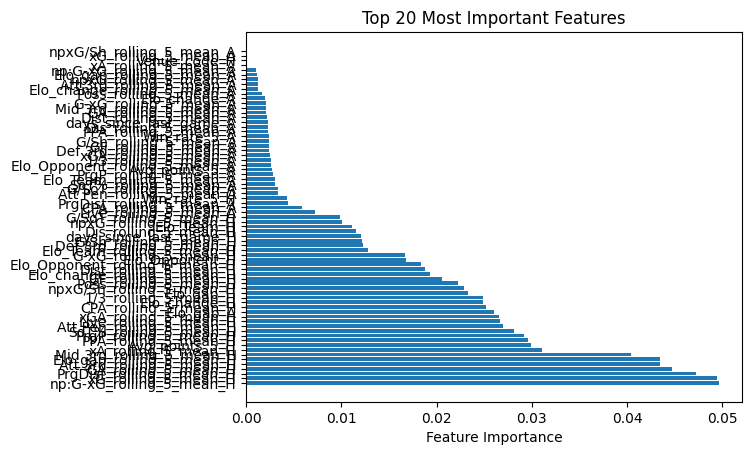

In [3]:
import matplotlib.pyplot as plt
from model.predict import load_model
model = load_model(r"C:\Users\48666\Desktop\Patryk\python\Projekty\PL_match_predictor\models\xgb_20251113_100531.pkl")
# Po treningu:
importance = model.feature_importances_
feature_names = X_train.columns

# Top 20 features
top_indices = importance.argsort()[:][::-1]
plt.barh(range(71), importance[top_indices])
plt.yticks(range(71), [feature_names[i] for i in top_indices])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features')
plt.show()

In [23]:
import numpy as np
# wezmiemy featury ktore dadza 0.95 importance

sorted_idx = np.argsort(importance)[::-1]
sorted_importance = importance[sorted_idx]
sorted_features = feature_names[sorted_idx]

cumsum = np.cumsum(sorted_importance)
cumsum_pct = cumsum * 100
cumsum_pct
# Znajdź ile features dla 95%
n_features_95 = np.where(cumsum_pct >= 95)[0][0] + 1
n_features_90 = np.where(cumsum_pct >= 90)[0][0] + 1
n_features_99 = np.where(cumsum_pct >= 99)[0][0] + 1
n_features_95

np.int64(44)

In [25]:
selected_features_95 = sorted_features[:n_features_95]
removed_features = sorted_features[n_features_95:]
# Nowy dataset
X_train_95 = X_train[selected_features_95]
X_test_95 = X_test[selected_features_95]
results_95 = train_model(
    X_train_95, y_train, X_test_95, y_test,
    do_tuning=False,
    name_prefix="selected_95pct"
)
print(results_95['metrics']['classification_report'])
print(results_95['metrics']['confusion_matrix'])

✅ Model zapisany: models/selected_95pct_20251114_011201.pkl
📊 Wyniki: {'accuracy': 0.5075406032482599, 'balanced_accuracy': 0.5217607494517161, 'f1_macro': 0.49542166265289816, 'f1_weighted': 0.524502174398823, 'confusion_matrix': array([[231,  86,  18],
       [ 88, 152, 164],
       [127, 366, 492]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.518     0.690     0.592       335\n           1      0.252     0.376     0.302       404\n           2      0.730     0.499     0.593       985\n\n    accuracy                          0.508      1724\n   macro avg      0.500     0.522     0.495      1724\nweighted avg      0.577     0.508     0.525      1724\n'}
              precision    recall  f1-score   support

           0      0.518     0.690     0.592       335
           1      0.252     0.376     0.302       404
           2      0.730     0.499     0.593       985

    accuracy                          0.508      1724
   ma

In [27]:
selected_features_99 = sorted_features[:n_features_99]
removed_features = sorted_features[n_features_99:]
# Nowy dataset
X_train_99 = X_train[selected_features_99]
X_test_99 = X_test[selected_features_99]
results_99 = train_model(
    X_train_99, y_train, X_test_99, y_test,
    do_tuning=False,
    name_prefix="selected_99pct"
)
print(results_99['metrics']['classification_report'])
print(results_99['metrics']['confusion_matrix'])

✅ Model zapisany: models/selected_99pct_20251114_011327.pkl
📊 Wyniki: {'accuracy': 0.5023201856148491, 'balanced_accuracy': 0.5448023115062472, 'f1_macro': 0.5045152531908584, 'f1_weighted': 0.5195984561117278, 'confusion_matrix': array([[227,  87,  21],
       [ 95, 211,  98],
       [120, 437, 428]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.514     0.678     0.584       335\n           1      0.287     0.522     0.371       404\n           2      0.782     0.435     0.559       985\n\n    accuracy                          0.502      1724\n   macro avg      0.528     0.545     0.505      1724\nweighted avg      0.614     0.502     0.520      1724\n'}
              precision    recall  f1-score   support

           0      0.514     0.678     0.584       335
           1      0.287     0.522     0.371       404
           2      0.782     0.435     0.559       985

    accuracy                          0.502      1724
   ma

In [28]:
selected_features_90 = sorted_features[:n_features_90]
removed_features = sorted_features[n_features_90:]
# Nowy dataset
X_train_90 = X_train[selected_features_90]
X_test_90 = X_test[selected_features_90]
results_90 = train_model(
    X_train_90, y_train, X_test_90, y_test,
    do_tuning=False,
    name_prefix="selected_90pct"
)
print(results_90['metrics']['classification_report'])
print(results_90['metrics']['confusion_matrix'])

✅ Model zapisany: models/selected_90pct_20251114_011512.pkl
📊 Wyniki: {'accuracy': 0.5777262180974478, 'balanced_accuracy': 0.5610783345172915, 'f1_macro': 0.5391723713878941, 'f1_weighted': 0.5880943329637861, 'confusion_matrix': array([[230,  83,  22],
       [ 91, 150, 163],
       [130, 239, 616]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.510     0.687     0.585       335\n           1      0.318     0.371     0.342       404\n           2      0.769     0.625     0.690       985\n\n    accuracy                          0.578      1724\n   macro avg      0.532     0.561     0.539      1724\nweighted avg      0.613     0.578     0.588      1724\n'}
              precision    recall  f1-score   support

           0      0.510     0.687     0.585       335
           1      0.318     0.371     0.342       404
           2      0.769     0.625     0.690       985

    accuracy                          0.578      1724
   ma

**Bazując na tym POC NIE MA SENSU robić feature selection**

Teraz zrobimy POC calibration (urealaniamy model)


📊 ANALYZING CALIBRATION (Uncalibrated Model)

🔍 Calibration Metrics (Uncalibrated):

Loss (class 0):
  Brier Score: 0.1345 (lower is better)
  Mean Predicted Prob: 0.259
  Actual Frequency:    0.194
  Difference:          0.065 ❌ POORLY CALIBRATED
  → Model is OVERCONFIDENT (predicts 25.9%, reality 19.4%)

Draw (class 1):
  Brier Score: 0.1978 (lower is better)
  Mean Predicted Prob: 0.355
  Actual Frequency:    0.234
  Difference:          0.121 ❌ POORLY CALIBRATED
  → Model is OVERCONFIDENT (predicts 35.5%, reality 23.4%)

Win (class 2):
  Brier Score: 0.2272 (lower is better)
  Mean Predicted Prob: 0.386
  Actual Frequency:    0.571
  Difference:          0.186 ❌ POORLY CALIBRATED
  → Model is UNDERCONFIDENT (predicts 38.6%, reality 57.1%)

📈 PLOTTING CALIBRATION CURVES


C:\Users\48666\AppData\Local\Temp\ipykernel_28772\3819336613.py:102: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\48666\AppData\Local\Temp\ipykernel_28772\3819336613.py:103: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig('calibration_uncalibrated.png', dpi=150, bbox_inches='tight')
c:\Users\48666\Desktop\Patryk\python\Projekty\PL_match_predictor\pl_match_predictor_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


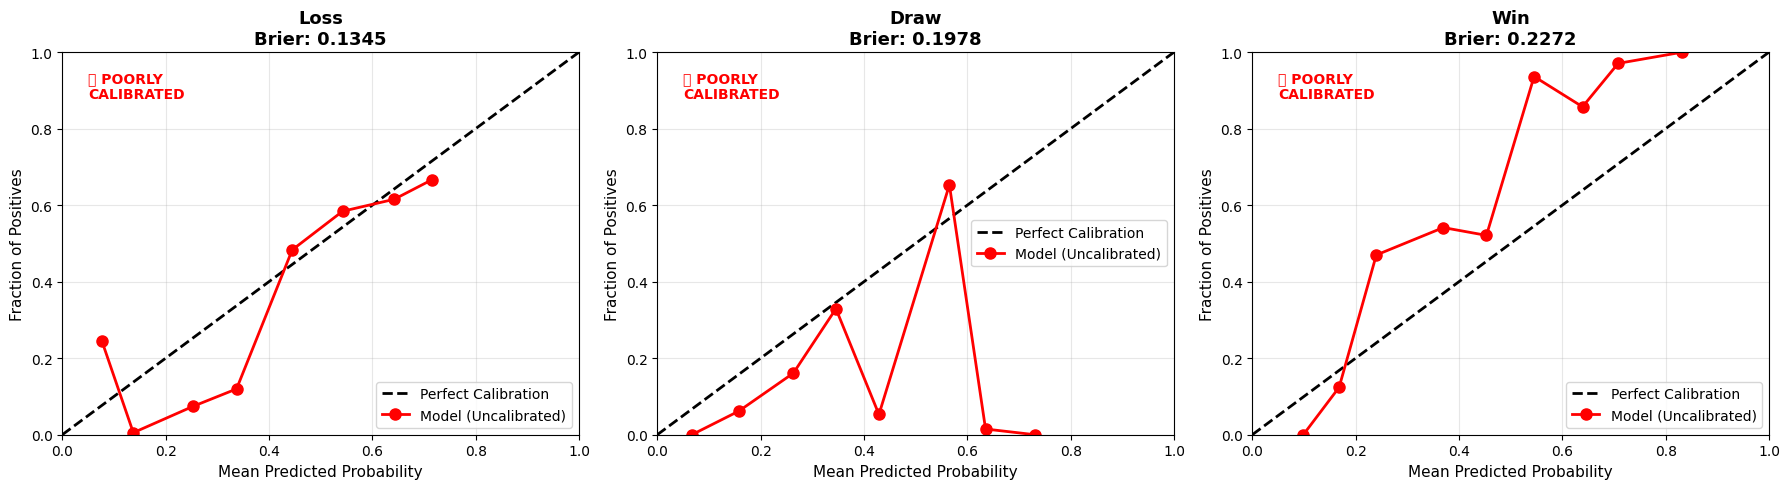

✅ Uncalibrated plot saved: calibration_uncalibrated.png

🔧 CALIBRATING MODEL (Sigmoid/Platt Scaling)

⏳ This may take 1-2 minutes (cross-validation)...
Split for calibration:
  Train: 4554 samples (for model refit)
  Val:   1139 samples (for calibration)

🔄 Retraining model on calibration split...


c:\Users\48666\Desktop\Patryk\python\Projekty\PL_match_predictor\pl_match_predictor_env\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


✅ Calibration complete!

📊 ANALYZING CALIBRATED MODEL

🔍 Calibration Metrics (Calibrated):

Loss:
  Brier (Uncalibrated): 0.1345
  Brier (Calibrated):   0.1351
  Improvement:          -0.4%
  Mean Pred (Calibrated): 0.189
  Actual Frequency:       0.194
  Difference:             0.005 ✅ WELL CALIBRATED

Draw:
  Brier (Uncalibrated): 0.1978
  Brier (Calibrated):   0.1916
  Improvement:          +3.2%
  Mean Pred (Calibrated): 0.181
  Actual Frequency:       0.234
  Difference:             0.053 ❌ STILL POORLY CALIBRATED

Win:
  Brier (Uncalibrated): 0.2272
  Brier (Calibrated):   0.2085
  Improvement:          +8.2%
  Mean Pred (Calibrated): 0.630
  Actual Frequency:       0.571
  Difference:             0.058 ❌ STILL POORLY CALIBRATED

📈 PLOTTING COMPARISON: UNCALIBRATED vs CALIBRATED


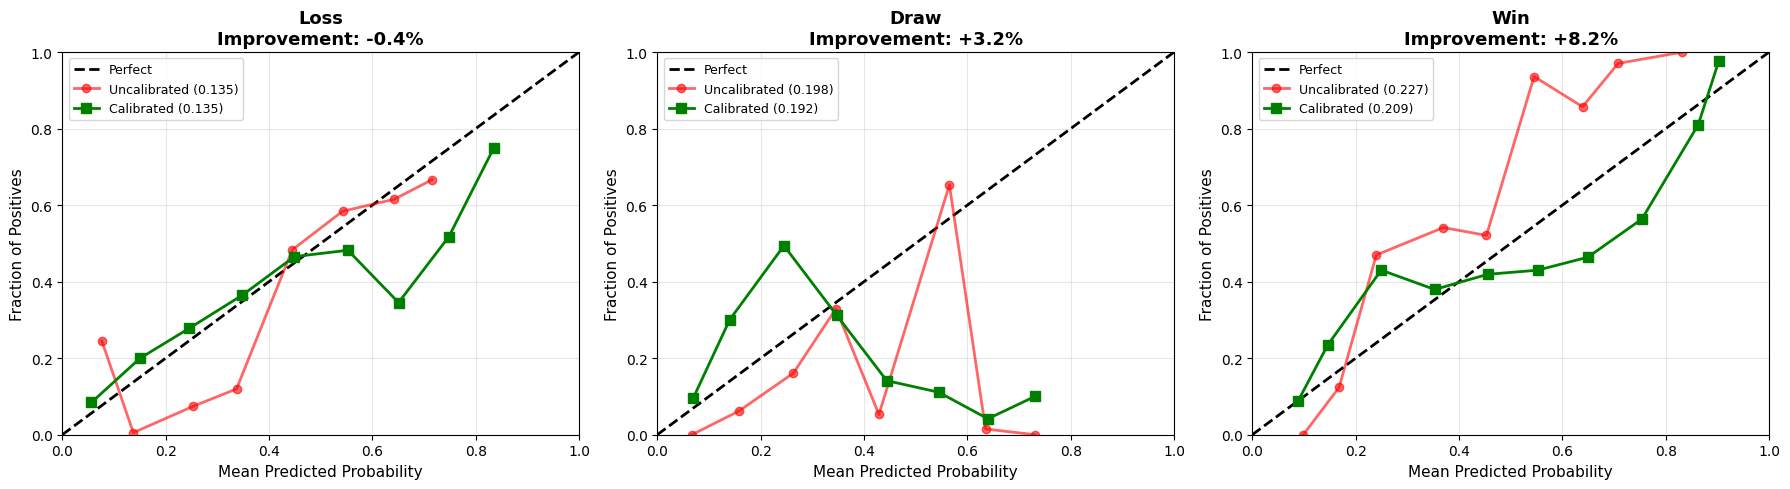

✅ Comparison plot saved: calibration_comparison.png

📊 EVALUATING MODEL PERFORMANCE

BASELINE (Uncalibrated):
              precision    recall  f1-score   support

           0      0.495     0.693     0.577       335
           1      0.376     0.361     0.369       404
           2      0.787     0.692     0.737       985

    accuracy                          0.615      1724
   macro avg      0.553     0.582     0.561      1724
weighted avg      0.634     0.615     0.619      1724


CALIBRATED:
              precision    recall  f1-score   support

           0      0.485     0.382     0.427       335
           1      0.176     0.052     0.080       404
           2      0.636     0.866     0.733       985

    accuracy                          0.581      1724
   macro avg      0.432     0.433     0.414      1724
weighted avg      0.499     0.581     0.521      1724


📊 SUMMARY: UNCALIBRATED vs CALIBRATED

       Model  F1_Macro  Balanced_Acc  Accuracy  Avg_Brier
Uncalibrated  0.5

In [32]:
from model.train import train_model, evaluate
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, log_loss
print("\n" + "=" * 70)
print("📊 ANALYZING CALIBRATION (Uncalibrated Model)")
print("=" * 70)

y_proba_uncal = model.predict_proba(X_test)
class_names = ['Loss', 'Draw', 'Win']

print("\n🔍 Calibration Metrics (Uncalibrated):")

calibration_data = []

for i, class_name in enumerate(class_names):
    # Binary labels dla tej klasy
    y_binary = (y_test == i).astype(int)
    proba_class = y_proba_uncal[:, i]
    
    # Brier score (lower = better, perfect = 0)
    brier = brier_score_loss(y_binary, proba_class)
    
    # Mean predicted vs actual
    mean_pred = proba_class.mean()
    actual_freq = y_binary.mean()
    diff = abs(mean_pred - actual_freq)
    
    print(f"\n{class_name} (class {i}):")
    print(f"  Brier Score: {brier:.4f} (lower is better)")
    print(f"  Mean Predicted Prob: {mean_pred:.3f}")
    print(f"  Actual Frequency:    {actual_freq:.3f}")
    print(f"  Difference:          {diff:.3f} ", end="")
    
    if diff < 0.02:
        print("✅ WELL CALIBRATED")
    elif diff < 0.05:
        print("⚠️  SLIGHTLY OFF")
    else:
        print("❌ POORLY CALIBRATED")
    
    if mean_pred > actual_freq:
        print(f"  → Model is OVERCONFIDENT (predicts {mean_pred:.1%}, reality {actual_freq:.1%})")
    else:
        print(f"  → Model is UNDERCONFIDENT (predicts {mean_pred:.1%}, reality {actual_freq:.1%})")
    
    calibration_data.append({
        'class': class_name,
        'brier': brier,
        'mean_pred': mean_pred,
        'actual_freq': actual_freq,
        'diff': diff
    })

# ============================================================
# KROK 3: Wizualizacja calibration curves (uncalibrated)
# ============================================================

print("\n" + "=" * 70)
print("📈 PLOTTING CALIBRATION CURVES")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, class_name in enumerate(class_names):
    y_binary = (y_test == i).astype(int)
    proba_class = y_proba_uncal[:, i]
    
    # Calibration curve
    fraction_pos, mean_pred_value = calibration_curve(
        y_binary, proba_class, n_bins=10, strategy='uniform'
    )
    
    # Plot
    ax = axes[i]
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect Calibration')
    ax.plot(mean_pred_value, fraction_pos, 'o-', linewidth=2, 
            markersize=8, color='red', label='Model (Uncalibrated)')
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=11)
    ax.set_ylabel('Fraction of Positives', fontsize=11)
    ax.set_title(f'{class_name}\nBrier: {calibration_data[i]["brier"]:.4f}', 
                 fontsize=13, fontweight='bold')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Annotation
    if calibration_data[i]['diff'] > 0.05:
        ax.text(0.05, 0.95, '❌ POORLY\nCALIBRATED', 
                transform=ax.transAxes, fontsize=10, 
                verticalalignment='top', color='red', fontweight='bold')
    elif calibration_data[i]['diff'] > 0.02:
        ax.text(0.05, 0.95, '⚠️  SLIGHTLY\nOFF', 
                transform=ax.transAxes, fontsize=10, 
                verticalalignment='top', color='orange', fontweight='bold')
    else:
        ax.text(0.05, 0.95, '✅ WELL\nCALIBRATED', 
                transform=ax.transAxes, fontsize=10, 
                verticalalignment='top', color='green', fontweight='bold')

plt.tight_layout()
plt.savefig('calibration_uncalibrated.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Uncalibrated plot saved: calibration_uncalibrated.png")

# ============================================================
# KROK 4: Calibrate model (Sigmoid method)
# ============================================================

print("\n" + "=" * 70)
print("🔧 CALIBRATING MODEL (Sigmoid/Platt Scaling)")
print("=" * 70)

print("\n⏳ This may take 1-2 minutes (cross-validation)...")

# Split train na train/validation dla calibration
from sklearn.model_selection import train_test_split

X_train_cal, X_val_cal, y_train_cal, y_val_cal = train_test_split(
    X_train, y_train, 
    test_size=0.2,  # 20% dla calibration
    random_state=42,
    stratify=y_train  # Zachowaj proporcje klas
)

print(f"Split for calibration:")
print(f"  Train: {len(X_train_cal)} samples (for model refit)")
print(f"  Val:   {len(X_val_cal)} samples (for calibration)")

# Opcja 1: Retrain model na mniejszym zbiorze (bez early stopping issues)
print("\n🔄 Retraining model on calibration split...")
from model.train import build_xgb_base

calibration_model = build_xgb_base()
# Trenuj bez early stopping (bo używamy prefit później)
calibration_model.set_params(early_stopping_rounds=None)

from sklearn.utils.class_weight import compute_sample_weight

# Sample weights
weights_cal = compute_sample_weight('balanced', y_train_cal)
draw_mask = (y_train_cal == 1)
weights_cal[draw_mask] *= 1.1

calibration_model.fit(
    X_train_cal, y_train_cal,
    sample_weight=weights_cal,
    verbose=False
)

# Calibrate używając cv='prefit' (nie retrenuje, tylko kalibruje na val set)
calibrated_model = CalibratedClassifierCV(
    calibration_model,
    method='sigmoid',
    cv='prefit'  # ← KLUCZOWE! Nie retrenuje, używa prefitted model
)

# Fit tylko kalibruje prawdopodobieństwa na validation set
calibrated_model.fit(X_val_cal, y_val_cal)
# ⬆️⬆️⬆️ KONIEC ZMIAN ⬆️⬆️⬆️

print("✅ Calibration complete!")

# ============================================================
# KROK 5: Analiza calibrated model
# ============================================================

print("\n" + "=" * 70)
print("📊 ANALYZING CALIBRATED MODEL")
print("=" * 70)

y_proba_cal = calibrated_model.predict_proba(X_test)

print("\n🔍 Calibration Metrics (Calibrated):")

calibration_data_cal = []

for i, class_name in enumerate(class_names):
    y_binary = (y_test == i).astype(int)
    proba_class_cal = y_proba_cal[:, i]
    proba_class_uncal = y_proba_uncal[:, i]
    
    # Brier scores
    brier_cal = brier_score_loss(y_binary, proba_class_cal)
    brier_uncal = brier_score_loss(y_binary, proba_class_uncal)
    brier_improvement = ((brier_uncal - brier_cal) / brier_uncal) * 100
    
    # Mean predicted vs actual
    mean_pred_cal = proba_class_cal.mean()
    actual_freq = y_binary.mean()
    diff_cal = abs(mean_pred_cal - actual_freq)
    
    print(f"\n{class_name}:")
    print(f"  Brier (Uncalibrated): {brier_uncal:.4f}")
    print(f"  Brier (Calibrated):   {brier_cal:.4f}")
    print(f"  Improvement:          {brier_improvement:+.1f}%")
    print(f"  Mean Pred (Calibrated): {mean_pred_cal:.3f}")
    print(f"  Actual Frequency:       {actual_freq:.3f}")
    print(f"  Difference:             {diff_cal:.3f} ", end="")
    
    if diff_cal < 0.02:
        print("✅ WELL CALIBRATED")
    elif diff_cal < 0.05:
        print("⚠️  SLIGHTLY OFF")
    else:
        print("❌ STILL POORLY CALIBRATED")
    
    calibration_data_cal.append({
        'class': class_name,
        'brier_uncal': brier_uncal,
        'brier_cal': brier_cal,
        'improvement': brier_improvement,
        'mean_pred': mean_pred_cal,
        'actual_freq': actual_freq,
        'diff': diff_cal
    })

# ============================================================
# KROK 6: Comparison plots (uncal vs cal)
# ============================================================

print("\n" + "=" * 70)
print("📈 PLOTTING COMPARISON: UNCALIBRATED vs CALIBRATED")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, class_name in enumerate(class_names):
    y_binary = (y_test == i).astype(int)
    
    # Uncalibrated
    proba_uncal = y_proba_uncal[:, i]
    frac_uncal, mean_uncal = calibration_curve(
        y_binary, proba_uncal, n_bins=10, strategy='uniform'
    )
    
    # Calibrated
    proba_cal = y_proba_cal[:, i]
    frac_cal, mean_cal = calibration_curve(
        y_binary, proba_cal, n_bins=10, strategy='uniform'
    )
    
    # Plot
    ax = axes[i]
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect')
    ax.plot(mean_uncal, frac_uncal, 'o-', linewidth=2, markersize=6,
            color='red', alpha=0.6, label=f'Uncalibrated ({calibration_data_cal[i]["brier_uncal"]:.3f})')
    ax.plot(mean_cal, frac_cal, 's-', linewidth=2, markersize=7,
            color='green', label=f'Calibrated ({calibration_data_cal[i]["brier_cal"]:.3f})')
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=11)
    ax.set_ylabel('Fraction of Positives', fontsize=11)
    ax.set_title(f'{class_name}\nImprovement: {calibration_data_cal[i]["improvement"]:+.1f}%', 
                 fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('calibration_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Comparison plot saved: calibration_comparison.png")

# ============================================================
# KROK 7: Evaluate performance (F1, accuracy, etc.)
# ============================================================

print("\n" + "=" * 70)
print("📊 EVALUATING MODEL PERFORMANCE")
print("=" * 70)
baseline_metrics = evaluate(model, X_test,y_test)
calibrated_metrics = evaluate(calibrated_model, X_test, y_test)

print("\nBASELINE (Uncalibrated):")
print(baseline_metrics['classification_report'])

print("\nCALIBRATED:")
print(calibrated_metrics['classification_report'])

# ============================================================
# KROK 8: Summary comparison
# ============================================================

print("\n" + "=" * 70)
print("📊 SUMMARY: UNCALIBRATED vs CALIBRATED")
print("=" * 70)

comparison = pd.DataFrame({
    'Model': ['Uncalibrated', 'Calibrated'],
    'F1_Macro': [
        baseline_metrics['f1_macro'],
        calibrated_metrics['f1_macro']
    ],
    'Balanced_Acc': [
        baseline_metrics['balanced_accuracy'],
        calibrated_metrics['balanced_accuracy']
    ],
    'Accuracy': [
        baseline_metrics['accuracy'],
        calibrated_metrics['accuracy']
    ],
    'Avg_Brier': [
        np.mean([d['brier'] for d in calibration_data]),
        np.mean([d['brier_cal'] for d in calibration_data_cal])
    ]
})

print("\n" + comparison.to_string(index=False))

# Calculate changes
f1_change = calibrated_metrics['f1_macro'] - baseline_metrics['f1_macro']
f1_change_pct = (f1_change / baseline_metrics['f1_macro']) * 100
brier_change = comparison.loc[1, 'Avg_Brier'] - comparison.loc[0, 'Avg_Brier']
brier_change_pct = (brier_change / comparison.loc[0, 'Avg_Brier']) * 100

print(f"\n💡 CHANGES:")
print(f"   F1-macro:    {f1_change:+.4f} ({f1_change_pct:+.1f}%)")
print(f"   Avg Brier:   {brier_change:+.4f} ({brier_change_pct:+.1f}%)")

# ============================================================
# KROK 9: Practical example (betting scenario)
# ============================================================

print("\n" + "=" * 70)
print("🎲 PRACTICAL EXAMPLE: Betting Scenario")
print("=" * 70)

# Weź pierwszy mecz z test set
sample_idx = 0
sample_proba_uncal = y_proba_uncal[sample_idx]
sample_proba_cal = y_proba_cal[sample_idx]
sample_true = y_test.iloc[sample_idx]

print(f"\n📋 Sample Match (index {sample_idx}):")
print(f"   True result: {class_names[sample_true]}")
print(f"\n   Uncalibrated probabilities:")
print(f"      Loss: {sample_proba_uncal[0]:.1%}")
print(f"      Draw: {sample_proba_uncal[1]:.1%}")
print(f"      Win:  {sample_proba_uncal[2]:.1%}")
print(f"\n   Calibrated probabilities:")
print(f"      Loss: {sample_proba_cal[0]:.1%}")
print(f"      Draw: {sample_proba_cal[1]:.1%}")
print(f"      Win:  {sample_proba_cal[2]:.1%}")

# Symuluj bookmaker odds
bookmaker_odds = [4.5, 3.5, 1.85]  # Przykładowe kursy [Loss, Draw, Win]
bookmaker_prob = [1/odd for odd in bookmaker_odds]

print(f"\n   Bookmaker odds (implied prob):")
print(f"      Loss: {bookmaker_odds[0]} ({bookmaker_prob[0]:.1%})")
print(f"      Draw: {bookmaker_odds[1]} ({bookmaker_prob[1]:.1%})")
print(f"      Win:  {bookmaker_odds[2]} ({bookmaker_prob[2]:.1%})")

# Value bets
print(f"\n   💰 Value Betting Analysis:")
for i, outcome in enumerate(class_names):
    edge_uncal = (sample_proba_uncal[i] - bookmaker_prob[i]) / bookmaker_prob[i] * 100
    edge_cal = (sample_proba_cal[i] - bookmaker_prob[i]) / bookmaker_prob[i] * 100
    
    print(f"\n   {outcome}:")
    print(f"      Uncalibrated edge: {edge_uncal:+.1f}%")
    print(f"      Calibrated edge:   {edge_cal:+.1f}%")
    
    if edge_cal > 5:
        print(f"      → ✅ VALUE BET! (calibrated model)")
    elif edge_uncal > 5 and edge_cal < 5:
        print(f"      → ⚠️  Uncalibrated says YES, calibrated says NO")
    else:
        print(f"      → ❌ No value")

# ============================================================
# CONCLUSION
# ============================================================

print("\n" + "=" * 70)
print("🎯 CONCLUSION")
print("=" * 70)

if abs(f1_change_pct) < 1:
    print(f"\n✅ F1-macro is STABLE ({f1_change_pct:+.1f}%)")
elif f1_change_pct > 0:
    print(f"\n✅ F1-macro IMPROVED by {f1_change_pct:.1f}%")
else:
    print(f"\n⚠️  F1-macro DECLINED by {abs(f1_change_pct):.1f}%")

if brier_change_pct < -5:
    print(f"✅ Brier score IMPROVED significantly ({brier_change_pct:.1f}%)")
    print(f"   → Probabilities are MORE RELIABLE!")
elif brier_change_pct < 0:
    print(f"✅ Brier score improved slightly ({brier_change_pct:.1f}%)")
else:
    print(f"❌ Brier score got worse ({brier_change_pct:+.1f}%)")

print(f"\n💡 RECOMMENDATION FOR BETTING:")
if brier_change_pct < -3:
    print(f"   ✅ USE CALIBRATED MODEL!")
    print(f"   Calibration significantly improves probability estimates.")
    print(f"   This is CRITICAL for value betting strategies.")
elif abs(f1_change_pct) < 1 and brier_change_pct < 0:
    print(f"   ✅ USE CALIBRATED MODEL!")
    print(f"   F1 is stable, but probabilities are better.")
else:
    print(f"   ⚠️  CONSIDER keeping uncalibrated")
    print(f"   Calibration didn't help much in your case.")

print("\n" + "=" * 70)
print("✅ PROOF OF CONCEPT COMPLETE!")
print("=" * 70)


In [1]:
# ============================================================================
# MINIMALISTIC FEATURE ENGINEERING - 7 NEW FEATURES
# Add to your Jupyter notebook for testing
# ============================================================================

import pandas as pd
import numpy as np
from datetime import timedelta

def add_h2h_features(df):
    """
    Dodaje head-to-head features (ostatnie 5 meczów między tymi samymi drużynami)
    
    Features:
    - h2h_home_wins: liczba wygranych home team w ostatnich 5 H2H
    - h2h_draws: liczba remisów w ostatnich 5 H2H
    - h2h_home_goals_avg: średnia goli home team w ostatnich 5 H2H
    """
    print("🔄 Adding H2H features...")
    
    df = df.copy()
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Initialize columns
    df['h2h_home_wins'] = 0
    df['h2h_draws'] = 0
    df['h2h_home_goals_avg'] = np.nan
    
    # Group by unique matchups
    for idx, row in df.iterrows():
        if idx % 500 == 0:
            print(f"  Processing row {idx}/{len(df)}...")
        
        home_team = row['Team']
        away_team = row['Opponent']
        current_date = row['Date']
        
        # Find all H2H matches BEFORE this match
        h2h_mask = (
            (
                ((df['Team'] == home_team) & (df['Opponent'] == away_team)) |
                ((df['Team'] == away_team) & (df['Opponent'] == home_team))
            ) &
            (df['Date'] < current_date)
        )
        
        h2h_matches = df[h2h_mask].tail(5)  # Last 5 H2H
        
        if len(h2h_matches) > 0:
            # From home team perspective
            home_perspective = h2h_matches[h2h_matches['Team'] == home_team]
            away_perspective = h2h_matches[h2h_matches['Team'] == away_team]
            
            # Count wins/draws
            home_wins = (home_perspective['Result'] == 'W').sum()
            away_wins = (away_perspective['Result'] == 'W').sum()
            
            # Total draws (from either perspective)
            total_draws = (h2h_matches['Result'] == 'D').sum()
            
            # Home goals
            if len(home_perspective) > 0:
                home_goals_avg = home_perspective['GF'].mean()
            else:
                # If no home matches, calculate from away perspective (GA of opponent)
                home_goals_avg = away_perspective['GA'].mean() if len(away_perspective) > 0 else np.nan
            
            df.loc[idx, 'h2h_home_wins'] = home_wins
            df.loc[idx, 'h2h_draws'] = total_draws
            df.loc[idx, 'h2h_home_goals_avg'] = home_goals_avg
    
    print(f"✅ H2H features added")
    print(f"   Matches with H2H history: {df['h2h_home_wins'].notna().sum()}/{len(df)}")
    
    return df


def add_form_vs_similar_features(df):
    """
    Dodaje features o formie przeciwko podobnym przeciwnikom (wg ELO)
    
    Features:
    - form_vs_similar_win_pct: win% przeciwko teams z podobnym ELO (±100)
    - form_vs_similar_goals_avg: średnia goli przeciwko similar opponents
    """
    print("🔄 Adding form vs similar opponents features...")
    
    df = df.copy()
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Initialize
    df['form_vs_similar_win_pct'] = np.nan
    df['form_vs_similar_goals_avg'] = np.nan
    
    for idx, row in df.iterrows():
        if idx % 500 == 0:
            print(f"  Processing row {idx}/{len(df)}...")
        
        team = row['Team']
        opponent_elo = row['Elo_Opponent']
        current_date = row['Date']
        
        # Define ELO range (±100)
        elo_min = opponent_elo - 100
        elo_max = opponent_elo + 100
        
        # Find matches against similar opponents BEFORE this match
        similar_mask = (
            (df['Team'] == team) &
            (df['Date'] < current_date) &
            (df['Elo_Opponent'] >= elo_min) &
            (df['Elo_Opponent'] <= elo_max)
        )
        
        similar_matches = df[similar_mask].tail(10)  # Last 10 matches
        
        if len(similar_matches) >= 3:  # Need at least 3 matches
            win_pct = (similar_matches['Result'] == 'W').mean()
            goals_avg = similar_matches['GF'].mean()
            
            df.loc[idx, 'form_vs_similar_win_pct'] = win_pct
            df.loc[idx, 'form_vs_similar_goals_avg'] = goals_avg
    
    print(f"✅ Form vs similar features added")
    print(f"   Matches with sufficient history: {df['form_vs_similar_win_pct'].notna().sum()}/{len(df)}")
    
    return df


def add_schedule_density_feature(df):
    """
    Dodaje feature o gęstości kalendarza
    
    Feature:
    - games_in_last_14_days: liczba meczów w ostatnich 14 dniach
    """
    print("🔄 Adding schedule density feature...")
    
    df = df.copy()
    df = df.sort_values(['Team', 'Date']).reset_index(drop=True)
    
    df['games_in_last_14_days'] = 0
    
    for team in df['Team'].unique():
        team_mask = df['Team'] == team
        team_df = df[team_mask].copy()
        
        for idx in team_df.index:
            current_date = df.loc[idx, 'Date']
            
            # Count games in last 14 days (excluding current match)
            date_14_days_ago = current_date - timedelta(days=14)
            
            recent_mask = (
                (df['Team'] == team) &
                (df['Date'] < current_date) &
                (df['Date'] >= date_14_days_ago)
            )
            
            games_count = recent_mask.sum()
            df.loc[idx, 'games_in_last_14_days'] = games_count
    
    print(f"✅ Schedule density feature added")
    print(f"   Avg games in 14 days: {df['games_in_last_14_days'].mean():.2f}")
    
    return df


def add_unbeaten_streak_feature(df):
    """
    Dodaje current unbeaten streak (W or D, no L)
    
    Feature:
    - current_unbeaten_streak: liczba meczów bez porażki (W/D) z rzędu
    """
    print("🔄 Adding unbeaten streak feature...")
    
    df = df.copy()
    df = df.sort_values(['Team', 'Date']).reset_index(drop=True)
    
    df['current_unbeaten_streak'] = 0
    
    for team in df['Team'].unique():
        team_mask = df['Team'] == team
        team_df = df[team_mask].copy()
        
        for idx in team_df.index:
            # Get results before this match
            previous_results = df.loc[
                (df['Team'] == team) & (df.index < idx), 
                'Result'
            ].tolist()
            
            # Calculate unbeaten streak
            streak = 0
            for result in reversed(previous_results):
                if result in ['W', 'D']:
                    streak += 1
                else:
                    break
            
            df.loc[idx, 'current_unbeaten_streak'] = streak
    
    print(f"✅ Unbeaten streak feature added")
    print(f"   Avg unbeaten streak: {df['current_unbeaten_streak'].mean():.2f}")
    print(f"   Max unbeaten streak: {df['current_unbeaten_streak'].max():.0f}")
    
    return df


def add_all_new_features(df):
    """
    Master function - dodaje wszystkie 7 nowych features
    """
    print("=" * 70)
    print("🚀 ADDING 7 NEW FEATURES - MINIMALISTIC APPROACH")
    print("=" * 70)
    
    # Check required columns
    required_cols = ['Team', 'Opponent', 'Date', 'Result', 'GF', 'GA', 'Elo_Opponent']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    
    # Ensure Date is datetime
    if df['Date'].dtype != 'datetime64[ns]':
        print("⚠️  Converting 'Date' to datetime...")
        df['Date'] = pd.to_datetime(df['Date'])
    
    initial_shape = df.shape
    print(f"\nInitial dataset: {initial_shape[0]} rows, {initial_shape[1]} columns")
    
    # Add features one by one
    df = add_h2h_features(df)
    df = add_form_vs_similar_features(df)
    df = add_unbeaten_streak_feature(df)
    
    final_shape = df.shape
    new_features = final_shape[1] - initial_shape[1]
    
    print("\n" + "=" * 70)
    print(f"✅ ALL FEATURES ADDED")
    print(f"   New columns: {new_features}")
    print(f"   Final dataset: {final_shape[0]} rows, {final_shape[1]} columns")
    print("=" * 70)
    
    # Summary statistics
    new_feature_cols = [
        'h2h_home_wins', 'h2h_draws', 'h2h_home_goals_avg',
        'form_vs_similar_win_pct', 'form_vs_similar_goals_avg',
        'current_unbeaten_streak'
    ]
    
    print("\n📊 NEW FEATURES SUMMARY:")
    for col in new_feature_cols:
        if col in df.columns:
            non_null = df[col].notna().sum()
            pct_non_null = (non_null / len(df)) * 100
            mean_val = df[col].mean()
            print(f"   {col:30s}: {non_null:5d}/{len(df)} ({pct_non_null:5.1f}%) non-null, mean={mean_val:.3f}")
    
    return df


# ============================================================================
# USAGE EXAMPLE
# ============================================================================



In [3]:
# ============================================================================
# COMPLETE SOLUTION: Add features to existing paired df
# ============================================================================

import pandas as pd
import numpy as np

# KROK 1: Wczytaj paired df
print("📂 Loading paired data...")
df_paired = pd.read_csv("train_df.csv", parse_dates=['Date'])
print(f"Loaded: {df_paired.shape}")

# KROK 2: Unpair (convert paired → unpaired)
print("\n🔄 Unpairing matches...")

def unpair_matches(df_paired):
    """Quick unpair function"""
    
    # Home perspective
    home_cols = {col: col[:-2] for col in df_paired.columns if col.endswith('_H')}
    home_df = df_paired.rename(columns=home_cols)
    home_df = home_df[[col for col in home_df.columns if not col.endswith('_A')]]
    home_df['Venue'] = 'Home'
    
    # Away perspective
    away_cols = {col: col[:-2] for col in df_paired.columns if col.endswith('_A')}
    away_df = df_paired.rename(columns=away_cols)
    away_df = away_df[[col for col in away_df.columns if not col.endswith('_H')]]
    away_df['Venue'] = 'Away'
    
    # Swap for away (Team<->Opponent, GF<->GA, Result)
    if 'Team' in away_df.columns and 'Opponent' in away_df.columns:
        away_df['Team'], away_df['Opponent'] = away_df['Opponent'].copy(), away_df['Team'].copy()
    if 'GF' in away_df.columns and 'GA' in away_df.columns:
        away_df['GF'], away_df['GA'] = away_df['GA'].copy(), away_df['GF'].copy()
    if 'Elo_Team' in away_df.columns and 'Elo_Opponent' in away_df.columns:
        away_df['Elo_Team'], away_df['Elo_Opponent'] = away_df['Elo_Opponent'].copy(), away_df['Elo_Team'].copy()
    if 'Result' in away_df.columns:
        away_df['Result'] = away_df['Result'].map({'W': 'L', 'L': 'W', 'D': 'D'})
    
    # Combine
    df_unpaired = pd.concat([home_df, away_df], ignore_index=True)
    df_unpaired = df_unpaired.sort_values('Date').reset_index(drop=True)
    
    return df_unpaired

df_unpaired = unpair_matches(df_paired)
print(f"✅ Unpaired: {df_unpaired.shape}")

# KROK 3: Add new features (copy-paste funkcje z wcześniej)
print("\n🚀 Adding new features...")

# [PASTE HERE: add_h2h_features, add_form_vs_similar_features, 
#               add_schedule_density_feature, add_unbeaten_streak_feature,
#               add_all_new_features functions]

df_enhanced = add_all_new_features(df_unpaired)

# KROK 4: Handle missing values
new_cols = [
    'h2h_home_wins', 'h2h_draws', 'h2h_home_goals_avg',
    'form_vs_similar_win_pct', 'form_vs_similar_goals_avg',
    'current_unbeaten_streak'
]
df_enhanced[new_cols] = df_enhanced[new_cols].fillna(0)

# KROK 5: Pair z powrotem
print("\n🔄 Pairing matches back...")

# Twoja funkcja pair_matches_to_one_row
from scraping.transform import pair_matches_to_one_row
df_final = pair_matches_to_one_row(df_enhanced)

#print(f"✅ Final paired df: {df_final.shape}")
#print(f"   Added {df_final.shape[1] - df_paired.shape[1]} new columns")

# KROK 6: Save
output_path = "train_df_with_new_features.csv"
df_final.to_csv(output_path, index=False)
print(f"\n💾 Saved to: {output_path}")

# KROK 7: Train model
print("\n🤖 Training model...")
from model.preprocessing import preprocess_for_model
from model.train import train_model

X_train, y_train, X_test, y_test = preprocess_for_model(df_final)

results = train_model(
    X_train, y_train, X_test, y_test,
    do_tuning=False,
    draw_boost=1.1
)

print("\n📊 RESULTS:")
print(results['metrics']['classification_report'])
print(f"F1-macro: {results['metrics']['f1_macro']:.3f}")
print(f"Baseline: 0.561")
print(f"Improvement: {((results['metrics']['f1_macro']/0.561)-1)*100:+.1f}%")

📂 Loading paired data...
Loaded: (7417, 157)

🔄 Unpairing matches...
✅ Unpaired: (14834, 84)

🚀 Adding new features...
🚀 ADDING 7 NEW FEATURES - MINIMALISTIC APPROACH

Initial dataset: 14834 rows, 84 columns
🔄 Adding H2H features...
  Processing row 0/14834...
  Processing row 500/14834...
  Processing row 1000/14834...
  Processing row 1500/14834...
  Processing row 2000/14834...
  Processing row 2500/14834...
  Processing row 3000/14834...
  Processing row 3500/14834...
  Processing row 4000/14834...
  Processing row 4500/14834...
  Processing row 5000/14834...
  Processing row 5500/14834...
  Processing row 6000/14834...
  Processing row 6500/14834...
  Processing row 7000/14834...
  Processing row 7500/14834...
  Processing row 8000/14834...
  Processing row 8500/14834...
  Processing row 9000/14834...
  Processing row 9500/14834...
  Processing row 10000/14834...
  Processing row 10500/14834...
  Processing row 11000/14834...
  Processing row 11500/14834...
  Processing row 12000/

AttributeError: 'NoneType' object has no attribute 'to_csv'

In [4]:
import pandas as pd
from scraping.transform import prepare_stats_df
from model.preprocessing import preprocess_for_model
from model.train import train_model


def train_prediction_model(df: pd.DataFrame):
    """
    ETAP 4: Preprocessing i trenowanie modelu
    
    Args:
        df: DataFrame z danymi po inżynierii cech
        
    Returns:
        dict: Wyniki trenowania modelu
    """
    print("\n" + "="*60)
    print("🤖 ETAP 4: TRENOWANIE MODELU")
    print("="*60)
    
    # Przygotowanie danych
    print("🔄 Przygotowuję dane...")
    df = prepare_stats_df(df)
    
    # Preprocessing dla modelu
    print("⚙️ Preprocessing danych...")
    X_train, y_train, X_test, y_test = preprocess_for_model(df)
    print(f"✅ Train set: {X_train.shape}, Test set: {X_test.shape}")
    
    # Trenowanie modelu
    print("🚀 Trenuję model...")
    wyniki = train_model(X_train, y_train, X_test, y_test, do_tuning=False)
    
    print("✅ Trenowanie zakończone!")
    
    return wyniki


df_transformed = pd.read_csv("train_df.csv", parse_dates=['Date'])
    # ETAP 4: Trenowanie modelu
wyniki = train_prediction_model(df_transformed)
    
    # Wyświetlanie końcowych wyników
print("\n" + "="*60)
print("🏆 PIPELINE ZAKOŃCZONY POMYŚLNIE!")
print("="*60)
print("\n📊 WYNIKI MODELU:")
print(wyniki)
print(wyniki['metrics']['classification_report'])
print("\n" + "="*60)



🤖 ETAP 4: TRENOWANIE MODELU
🔄 Przygotowuję dane...
⚙️ Preprocessing danych...
✅ Train set: (5693, 71), Test set: (1724, 71)
🚀 Trenuję model...
✅ Model zapisany: models/xgb_20251116_133748.pkl
📊 Wyniki: {'accuracy': 0.6148491879350348, 'balanced_accuracy': 0.5821030796162425, 'f1_macro': 0.5607674588203907, 'f1_weighted': 0.6193366542910272, 'confusion_matrix': array([[232,  81,  22],
       [ 95, 146, 163],
       [142, 161, 682]]), 'classification_report': '              precision    recall  f1-score   support\n\n           0      0.495     0.693     0.577       335\n           1      0.376     0.361     0.369       404\n           2      0.787     0.692     0.737       985\n\n    accuracy                          0.615      1724\n   macro avg      0.553     0.582     0.561      1724\nweighted avg      0.634     0.615     0.619      1724\n'}
✅ Trenowanie zakończone!

🏆 PIPELINE ZAKOŃCZONY POMYŚLNIE!

📊 WYNIKI MODELU:
{'model': XGBClassifier(base_score=None, booster=None, callbacks=No